In [8]:
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from data import sample_latents
from vis import *
from models import *

jac = torch.autograd.functional.jacobian

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [32]:
class AlphaAdd(Composition):
    """C for addition with alpha channel."""

    def __init__(self, clamp: bool = True):
        super().__init__()
        self.clamp = clamp

    def _alpha_add(self, a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
        """Add `a` over `b`."""
        alpha_a = a[:, :, :, -1].unsqueeze(-1)
        alpha_b = b[:, :, :, -1].unsqueeze(-1)
        if self.clamp:
            alpha_a = alpha_a.clamp(0, 1)
            alpha_b = alpha_b.clamp(0, 1)
        alpha = alpha_a + (1 - alpha_a) * alpha_b

        a = a[:, :, :, :3]
        b = b[:, :, :, :3]
        rgb = (alpha_a * a + (1 - alpha_a) * alpha_b * b) / alpha

        return torch.cat([rgb, alpha], dim=3)

    def forward(self, x: List[torch.Tensor]) -> torch.Tensor:
        if x.ndim < 3:
            raise RuntimeError(
                f"Add expects an input of shape [batch, slot, ...], but got shape {x.shape}"
            )

        # interpret channels as RGBa
        assert (
            x.ndim == 5 and x.shape[-1] == 4
        ), f"Expexted input to have shape [B, S, W, H, 4], but got {x.shape}."

        # paste everything onto an opaque black canvas
        out_rgb = torch.zeros_like(x[:, 0, :, :, :3])
        out_alpha = torch.ones_like(x[:, 0, :, :, 3])
        out = torch.cat([out_rgb, out_alpha.unsqueeze(-1)], dim=3)
        for slot in reversed(range(x.shape[1])):
            out = self._alpha_add(x[:, slot, :], out)

        return out

    def get_d_out(
        self, slot_d_out: Union[List[int], List[List[int]]]
    ) -> Union[int, List[int]]:
        return slot_d_out[0][:2] + [3]

In [33]:
D = [5, 5]
M = [[16, 16, 4], [16, 16, 4]]

# z = sample_latents(D, "orthogonal", n_samples=1000)
# z = scale_latents(z)

phi = ParallelSlots([SpriteworldRenderer(d_in, d_out) for d_in, d_out in zip(D, M)])
C = AlphaAdd()
f = CompositionalFunction(C, phi).to(dev)
f.eval()

# with torch.no_grad():
#     x, slots = f(z.to(dev), return_slot_outputs=True)

CompositionalFunction(
  (composition): AlphaAdd()
  (slots): ParallelSlots(
    (slot_functions): ModuleList(
      (0-1): 2 x SpriteworldRenderer()
    )
  )
)

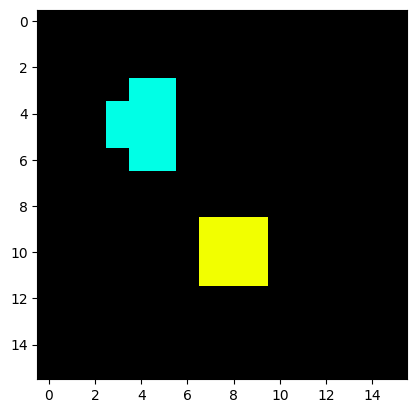

In [34]:
z = torch.rand(10).unsqueeze(0)
z = scale_latents(z)
slots = phi(z)
x = f(z)
plt.imshow(x[0])

In [35]:
dC_dphi = jac(C, slots)
dC_dphi.shape

In [40]:
batch_idx = 0
slot_idx = 1
# dC_dphi[batch_idx, :, :, :, batch_idx, slot_idx, :, :, :].flatten(0, 2).flatten(1, 3)
dC_dphi[batch_idx, :, :, 3, batch_idx, slot_idx, :, :, 3]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 